# Misclassification of athlete ECG by GE Marquette SL12 algorithm

The GE Marquette... commonly used...

This report will demonstrate that... consistently misdiagnose athletes...

## Notebook setup

In [1]:
#| code-fold: true
#| code-summary: "Click to see packages imported"
import os
import configparser
from pathlib import Path
from typing import TypedDict, List
from enum import Enum

import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#|include: false
# If the current working directory is the nbs/ folder, change to the project 
# root directory instead.

if Path.cwd().stem == "nbs":
    os.chdir(Path.cwd().parent)
print(f"The current working directory is {Path.cwd()}")

The current working directory is /Users/shaun/source/Thesis/PhysioNetChallenge2020


In [3]:
#|include: false
# Import configuration settings, like location of data directory.
config = configparser.ConfigParser()
if not Path("config.ini").exists():
    print("WARNING: Please generate a config.ini file by running scripts/get_datasets.py")
else:
    config.read("config.ini")
    data_dir = Path((config["datasets"]["path"])).expanduser()
    print(f"Datasets are located at {data_dir.resolve()}")

Datasets are located at /Users/shaun/source/Thesis/PhysioNetChallenge2020/data


## The norwegian-athlete-ecg dataset

The [Norwegian Endurance Athlete ECG Database](https://physionet.org/content/norwegian-athlete-ecg/1.0.0/) (norwegian-athlete-ecg) contains 12-lead ECG recordings from 28 elite athletes from various sports in Norway. All recordings are 10 seconds resting ECGs recorded with a General Electric (GE) MAC VUE 360 electrocardiograph. All ECGs are interpreted with both the GE Marquette SL12 algorithm (version 23 (v243)) and one cardiologist with training in interpretation of athlete's ECG. The data was collected at the University of Oslo in February and March 2020.

In [4]:
athlete_ecg_dir = data_dir / "norwegian-athlete-ecg" / "1.0.0"

An example of the data for athlete `ath_001` is shown below.

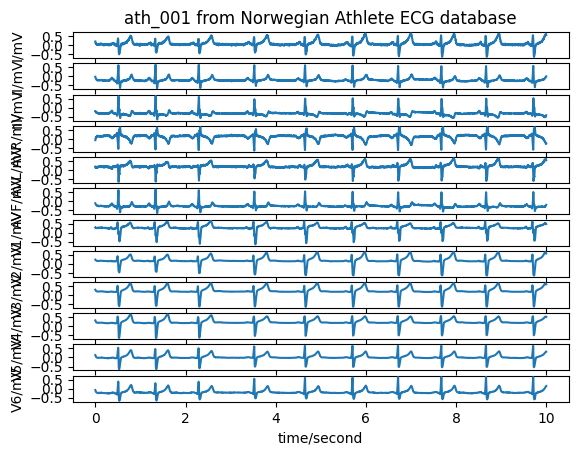

In [5]:
#| output: show
# 12-lead ECG recording from subject ath_001
record = wfdb.rdrecord(athlete_ecg_dir / "ath_001")
wfdb.plot_wfdb(record=record, title='ath_001 from Norwegian Athlete ECG database')

In [6]:
#| output: show
# Machine (SL12) and Cardiologist (C) interpretation of ath_001 ECG recording
record = wfdb.rdheader(athlete_ecg_dir / "ath_001")
record.__dict__["comments"]

['SL12: Sinus bradycardia with marked sinus arrhythmia, Right axis deviation, Borderline ECG',
 'C: Sinus arrhythmia,  Normal ECG']

In [7]:
#| code-fold: true
#| code-summary: Put ECG finding reports into a pandas dataframe
class AthleteReport():
    athlete_id: str
    cardiologist: str
    machine: str

reports_list = []
for i in range(1, 29):
    athlete_id = f"ath_00{i}" if i < 10 else f"ath_0{i}"
    record = wfdb.rdheader(athlete_ecg_dir / athlete_id)
    comments = record.__dict__["comments"]
    report: AthleteReport = {
        "athlete_id": athlete_id,
        "cardiologist": comments[1],
        "machine": comments[0],
    }
    reports_list.append(report)
athlete_ecg_df = pd.DataFrame(reports_list)

In [8]:
#| output: show
athlete_ecg_df.head()

,athlete_id,cardiologist,machine
0,ath_001,"C: Sinus arrhythmia, Normal ECG",SL12: Sinus bradycardia with marked sinus arrh...
1,ath_002,"C: Sinus arrhythmia, Right axis deviation, Nor...",SL12: Sinus bradycardia with marked sinus arrh...
2,ath_003,"C: Normal sinus rhythm, Left axis deviation, B...",SL12: Sinus bradycardia with marked sinus arrh...
3,ath_004,"C: Normal sinus rhythm, Normal ECG","SL12: Sinus bradycardia, Right axis deviation,..."
4,ath_005,"C: Sinus bradycardia, normal sinus rhythm, Fir...",SL12: Sinus bradycardia and sinus arrhythmia a...


## Findings from ECG reports

In the norwegian-athlete-ecg dataset, findings in ECG reports are delimited by 
a comma (`,`). However, some machine findings also make use of a comma to make 
a follow-up comment on a finding. This is not done in any of the human 
cardiologist reports in the dataset.

***Table: Examples of findings with follow-up comment***

| Finding with follow-up comment | Record |
|-|-|
| `Minimal voltage criteria for LVH, may be normal variant` | `ath_024` |
| `ST elevation, probably due to early repolarization` | `ath_024` |
| `ST elevation, consider early repolarization, pericarditis, or injury` | `ath_27` |

Follow-up comments from SL12 all seem to start with a lower-case letter, so 
they can be detected this way.

In [9]:
#| code-fold: true
#| code-summary: Click to see function for extracting a list of findings from a single line report

def extract_findings(report: str, follow_on: bool=True) -> List[str]:
    """Extract a list of all findings in a single line cardiologist report
    """
    comments = report.split(': ', maxsplit=1)[1].split(', ')

    # Cleanup (e.g. remove leading/trailing whitespace)
    comments[:] = list(map(str.strip, comments))

    if not follow_on:
        return comments     # i.e. assume every comment is a new finding

    # Combine follow-on comments with parent comment to produce full finding 
    # for SL12 machine comments.
    #
    # e.g. ST elevation, consider early repolarization, pericarditis, or injury
    findings = []
    for i, comment in enumerate(comments):
        if comment[0].isupper() or comment[0] == '*':
            findings.append(comment)
        else:
            findings[-1] = ''.join([findings[-1], ", ", comment])
    return findings

In [10]:
#| output: show
# Example usage of `extract_findings()`
report = athlete_ecg_df.loc[23].machine
extract_findings(report)

['Sinus bradycardia',
 'Incomplete right bundle branch block',
 'Minimal voltage criteria for LVH, may be normal variant',
 'ST elevation, probably due to early repolarization',
 'Borderline ECG']

In [11]:
# Find every unique finding in dataset
unique_findings_sl12 = []
unique_findings_c = []
for i in range(1, 29):
    athlete_id = f"ath_00{i}" if i < 10 else f"ath_0{i}"
    record = wfdb.rdheader(athlete_ecg_dir / athlete_id)
    comments = record.__dict__["comments"]

    # Machine algorithm findings
    findings_sl12 = extract_findings(comments[0])
    for finding in findings_sl12:
        if finding not in unique_findings_sl12:
            unique_findings_sl12.append(finding)
    
    # Cardiologist findings
    findings_c = extract_findings(comments[1], follow_on=False)
    for finding in findings_c:
        if finding not in unique_findings_c:
            unique_findings_c.append(finding)


In [12]:
#| output: show
unique_findings_c

['Sinus arrhythmia',
 'Normal ECG',
 'Right axis deviation',
 'Normal sinus rhythm',
 'Left axis deviation',
 'Borderline ECG',
 'Sinus bradycardia',
 'normal sinus rhythm',
 'First degree AV block',
 'Left ventricular hypertrophy',
 'Incomplete right bundle branch block',
 'Possible left ventricular hypertrophy',
 'Left atrial enlargement',
 'Misplaced electrodes',
 'first degree AV block']

In [13]:
#| output: show
unique_findings_sl12

['Sinus bradycardia with marked sinus arrhythmia',
 'Right axis deviation',
 'Borderline ECG',
 'Left axis deviation',
 'Abnormal ECG',
 'Sinus bradycardia',
 'Sinus bradycardia and sinus arrhythmia and first degree AV block',
 'Otherwise normal ECG',
 '***Critical test result: STEMI',
 'Normal sinus rhythm',
 'Pulmonary disease pattern',
 'Incomplete right bundle branch block',
 'Possible right ventricular hypertrophy',
 'Cannot rule out inferior infarct age not determined',
 'Anterolateral injury pattern',
 '** ** ACUTE MI/STEMI** **',
 "RSR' or QR pattern in V1 suggests right ventricular conduction delay",
 'First degree AV block',
 'Right atrial enlargement',
 'Anterior infarction age not determined',
 'Lateral injury pattern',
 'Abnormal EKG',
 'Normal sinus rhythm with sinus arrhythmia',
 'Normal ECG',
 'Marked sinus bradycardia',
 'Lateral infarction age not determined',
 'Sinus rhythm with first degree AV block',
 'Sinus bradycardia with sinus arrhythmia',
 'ST elevation consid

## Disagreement between machine and cardiologist findings

TODO: Explanation of why athlete is likely to be misinterpreted. ECG interpretation guidelines for athletes.

### Overall finding

It is common practice to give an ECG recording or segment of a recording an 
overall finding of "normal", "borderline" or "abnormal" to aid clinical 
decision-making.

In the norwegian-athlete-ecg dataset, human cardiologists classified 2 
recordings as "borderline", and the remaining 26 as "normal". Observing the 
difference in overall finding between human cardiologist and SL12 algorithm 
gives an idea of the difficulty of interpretation posed by each recording.

In [14]:
#| code-fold: true
#| code-summary: Extract overall ECG findings from dataset and measure disagreement between C and SL12

# The final finding in each report is an "overall" classification for the 
# entire ECG recording.

# We can use the difference between machine and cardiologist `OverallFinding`
# values to quantify if the disagreement is "small" or "large".

class OverallFinding(Enum):
    Unknown = -99
    Normal = 0
    Borderline = 1
    Abnormal = 2

def classifyOverallFinding(findings: List[str]) -> OverallFinding:
    """Classifies the overall finding for an ECG recording.

    Assumes that the final finding in `findings` list comments on overall 
    finding.
    """
    overall = findings[-1].lower()
    if overall.find("abnormal") != -1:
        return OverallFinding.Abnormal
    elif overall.find("borderline") != -1:
        return OverallFinding.Borderline
    elif overall.find("normal") != -1:
        return OverallFinding.Normal
    else:
        return OverallFinding.Unknown

# Quantify the "overall disagreement" between cardiologist and SL12 algorithm.
count_0 = 0     # Agree
count_1 = 0     # Disagree (small)
count_2 = 0     # Disagree (large)

count_sl12_normal = 0
count_sl12_borderline = 0
count_sl12_abnormal = 0

for i in range(1, 29):
    athlete_id = f"ath_00{i}" if i < 10 else f"ath_0{i}"

    record = wfdb.rdheader(athlete_ecg_dir / athlete_id)
    comments = record.__dict__["comments"]

    findings_sl12 = extract_findings(comments[0])
    findings_c = extract_findings(comments[1])

    overall_sl12 = classifyOverallFinding(findings_sl12)
    overall_c = classifyOverallFinding(findings_c)

    if (overall_sl12.value - overall_c.value) == 0:
        count_0 += 1
    elif (overall_sl12.value - overall_c.value) == 1:
        count_1 += 1
    elif (overall_sl12.value - overall_c.value) == 2:
        count_2 += 1
    
    if (overall_sl12 == OverallFinding.Normal):
        count_sl12_normal += 1
    elif (overall_sl12 == OverallFinding.Borderline):
        count_sl12_borderline += 1
    elif (overall_sl12 == OverallFinding.Abnormal):
        count_sl12_abnormal += 1

    # print(f"{athlete_id} disagreement = {overall_sl12.value - overall_c.value}\tc = {overall_c.name}")


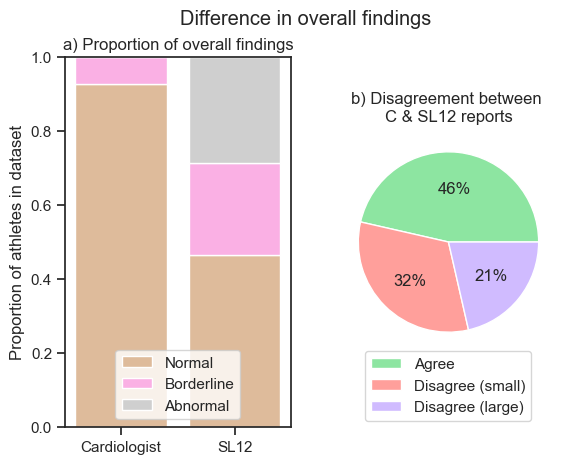

In [15]:
#| output: show
#| code-fold: true
#| code-summary: Plot difference between C and SL12 overall findings
sns.set_theme(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle("Difference in overall findings")

#
# Stacked bar charts showing ratio of normal/borderline/abnormal findings
#

colors = sns.color_palette('pastel')[5:8]
report_source = ["Cardiologist", "SL12"]
overall_finding_labels = ["Normal", "Borderline", "Abnormal"]
overall_findings_data = {
    "Normal": np.array([26, count_sl12_normal]) / 28.0,
    "Borderline": np.array([2, count_sl12_borderline]) / 28.0,
    "Abnormal": np.array([0, count_sl12_abnormal]) / 28.0,
}

# Iteratively build stacked bar chart, one finding class at a time.
bot_c = 0
bot_sl12 = 0
color_index = 0
for finding, counts in overall_findings_data.items():
    ax1.bar(
        report_source, 
        counts, 
        label=finding, 
        bottom=[bot_c, bot_sl12], 
        color=colors[color_index],
    )
    bot_c += counts[0]
    bot_sl12 += counts[1]
    color_index += 1

ax1.set_title("a) Proportion of overall findings")
ax1.set_ylabel("Proportion of athletes in dataset")
ax1.legend(loc="lower center")

# 
# Pie chart summarising overall disagreement
#

colors = sns.color_palette('pastel')[2:5]

ax2.pie(
    [count_0, count_1, count_2],
    colors = colors,
    autopct='%.0f%%',
    labeldistance=1.1,
    pctdistance=0.6,
)

ax2.legend(
    ["Agree", "Disagree (small)", "Disagree (large)"],
    bbox_to_anchor=(0.9, 0.05),
)
ax2.set_title("b) Disagreement between \nC & SL12 reports")

plt.show()

In [16]:
#| code-fold: true
#| code-summary: Add overall finding labels to pandas dataframe
athlete_ecg_df = athlete_ecg_df.assign(
    overall_c=list(map(lambda x: classifyOverallFinding( extract_findings(x, follow_on=False) ).name, athlete_ecg_df.cardiologist))
)

athlete_ecg_df = athlete_ecg_df.assign(
    overall_sl12=list(map(lambda x: classifyOverallFinding( extract_findings(x, follow_on=True) ).name, athlete_ecg_df.machine))
)

In [17]:
athlete_ecg_df.head()

,athlete_id,cardiologist,machine,overall_c,overall_sl12
0,ath_001,"C: Sinus arrhythmia, Normal ECG",SL12: Sinus bradycardia with marked sinus arrh...,Normal,Borderline
1,ath_002,"C: Sinus arrhythmia, Right axis deviation, Nor...",SL12: Sinus bradycardia with marked sinus arrh...,Normal,Borderline
2,ath_003,"C: Normal sinus rhythm, Left axis deviation, B...",SL12: Sinus bradycardia with marked sinus arrh...,Borderline,Abnormal
3,ath_004,"C: Normal sinus rhythm, Normal ECG","SL12: Sinus bradycardia, Right axis deviation,...",Normal,Borderline
4,ath_005,"C: Sinus bradycardia, normal sinus rhythm, Fir...",SL12: Sinus bradycardia and sinus arrhythmia a...,Normal,Normal


### Rhythm findings

TODO: Disagreement between cardiologist and machine for individual abnormality 
classes.

TODO: Add rhythm labels to dataset

In [18]:
# Classifying findings by the type of abnormality

class AbnormalityClass(Enum):
    # overall = "Overall ECG recording"   # Normal/Abnormal/Borderline etc.
    rhythm = "Rhythm"                   # e.g. sinus rhythm
    conduction = "Conduction"           # e.g. bundle branch block, AV block
    ischemia = "Ischemia"               # e.g. ST-segment, T-wave inversion
    structural = "Structural"           # e.g. chamber enlargement, hypertrophy
    measurement = "Measurement"         # e.g. axis deviation, wide QRS, PR interval
    equipment = "Equipment"             # e.g. Misplaced electrodes
    other = "Other"


## Exporting the labelled dataset